In [1]:
import os
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from omegaconf import OmegaConf

from metrics import *
from datasets.get_dataset import get_dataset
from datasets.base import BaseDataset

### Baseline (Train on all of the data)

In [2]:
args = OmegaConf.load('configs/waterbirds/base.yaml')
args.data.train_first_split = 'even'
base      = OmegaConf.load('configs/base.yaml')
args      = OmegaConf.merge(base, args)

torch.manual_seed(args.seed)
np.random.seed(args.seed)

dataset = BaseDataset(get_dataset(args.data.dataset, cfg=args, split='train'), args)

results_dir = f'predictions/{args.data.dataset}/{args.exp.run}'
first_split = pd.concat([pd.read_csv(f'{results_dir}/first-split/{f}') for f in os.listdir(os.path.join(results_dir, 'first-split'))])
second_split = pd.concat([pd.read_csv(f'{results_dir}/second-split/{f}') for f in os.listdir(os.path.join(results_dir, 'second-split'))])

# add in group column if it doesn't exist
if 'group' not in first_split.columns:
    first_split['group'] = np.array(dataset.dataset.groups)[first_split['image_id'].values]
first_split[:5]

Get dataset Waterbirds95


,image_id,stage,epoch,label,prediction,loss,conf,group
0,606,first-split,36,1.0,1.0,0.002090,0.997912,3.0
1,2588,first-split,36,0.0,0.0,0.026967,0.914652,0.0
2,3054,first-split,36,0.0,0.0,0.001304,0.995694,0.0
3,4390,first-split,36,0.0,0.0,0.000572,0.998110,0.0
4,4232,first-split,36,0.0,0.0,0.001530,0.994953,0.0


In [20]:
first_split['group'].value_counts()

0.0    349200
3.0    104400
1.0     19000
2.0      7000
Name: group, dtype: int64

### Get Metrics

In [21]:
## get metrics

fslt = first_split.groupby('image_id', as_index=False).apply(calc_fslt)
fslt.columns = ['image_id', 'fslt']

num_forgetting = first_split.groupby('image_id', as_index=False).apply(calc_num_forgetting)
num_forgetting.columns = ['image_id', 'num_forgetting']

num_flips = first_split.groupby('image_id', as_index=False).apply(calc_num_flips)
num_flips.columns = ['image_id', 'num_flips']

cumulative_learning = first_split.groupby('image_id', as_index=False).apply(calc_cumulative_learning)
cumulative_learning.columns = ['image_id', 'cumulative_learning']

cumulative_confidence = first_split.groupby('image_id', as_index=False).apply(calc_cumulative_confidence)
cumulative_confidence.columns = ['image_id', 'cumulative_confidence']

cumulative_loss = first_split.groupby('image_id', as_index=False).apply(calc_cumulative_loss)
cumulative_loss.columns = ['image_id', 'cumulative_loss']

conf_delta = first_split.groupby('image_id', as_index=False).apply(calc_conf_delta)
conf_delta.columns = ['image_id', 'conf_delta']

ssft = second_split.groupby('image_id', as_index=False).apply(calc_ssft)
ssft.columns = ['image_id', 'ssft']

In [22]:
results = pd.concat([fslt, ssft, num_forgetting, cumulative_learning, cumulative_confidence, cumulative_loss, conf_delta], axis=1)
results = results.loc[:,~results.columns.duplicated()].copy()
results = results.merge(first_split[['image_id', 'group', 'label']].drop_duplicates(), on='image_id')
results

,image_id,fslt,ssft,num_forgetting,cumulative_learning,cumulative_confidence,cumulative_loss,conf_delta,group,label
0,0,0,200,0,200,198.293213,1.926005,5.295028,3.0,1.0
1,2,0,200,0,200,198.542613,1.653432,4.764382,3.0,1.0
2,4,1,200,1,199,195.987953,4.516845,8.995221,3.0,1.0
3,6,0,200,0,200,196.860753,3.502148,7.723760,3.0,1.0
4,8,0,200,0,200,197.345998,2.960557,6.491155,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2393,4786,1,200,1,199,196.888698,1.112630,7.519632,0.0,0.0
2394,4788,0,200,0,200,196.604601,1.198112,8.190301,0.0,0.0
2395,4790,0,200,0,200,197.397593,0.912651,6.807570,0.0,0.0
2396,4792,0,200,0,200,198.406950,0.560683,5.115025,0.0,0.0


In [23]:
# compensate for weighted loss

weights = dataset.class_weights.numpy()
print(weights)
# weights /= weights.min()
def weight_loss(loss, label):
    return loss / weights[int(label)]

print(results['cumulative_loss'][results['label'] == 0].sum())
r = results
results['cumulative_loss'] = r.apply(lambda row : weight_loss(row['cumulative_loss'],
                     row['label']), axis=1)
print(results['cumulative_loss'][results['label'] == 0].sum())

[0.30228138 1.        ]
3741.083408702471
12376.16227773919


In [30]:
# how many images for each group are forgotten
metrics = ['fslt', 'ssft', 'num_forgetting', 'cumulative_learning',
       'cumulative_confidence', 'cumulative_loss', 'conf_delta']
results.sort_values('group').groupby('group')[metrics].mean()

,fslt,ssft,num_forgetting,cumulative_learning,cumulative_confidence,cumulative_loss,conf_delta
group,,,,,,,
0.0,0.978236,200.0,0.916380,199.060710,195.526542,5.390762,9.386477
1.0,17.147368,200.0,14.905263,183.305263,185.823324,31.198860,23.226402
2.0,11.714286,200.0,9.457143,189.428571,188.858910,20.177205,18.915821
3.0,1.017241,200.0,0.534483,199.425287,196.253650,4.584891,8.457888


In [29]:
results.sort_values('group').groupby('group')[metrics].max()

,fslt,ssft,num_forgetting,cumulative_learning,cumulative_confidence,cumulative_loss,conf_delta
group,,,,,,,
0.0,29,200,25,200,198.637125,46.230017,37.697720
1.0,57,200,48,200,198.046256,118.737337,38.338749
2.0,64,200,53,200,197.080732,103.823265,37.634514
3.0,188,200,23,200,199.027059,67.878877,33.801547


<AxesSubplot:xlabel='conf_delta', ylabel='cumulative_loss'>

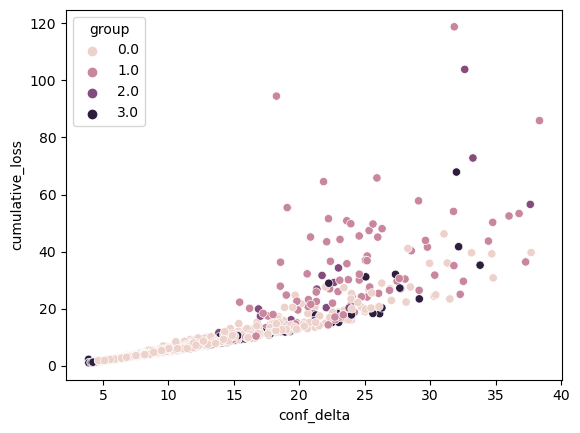

In [9]:
# results.groupby('num_forgetting')['fslt'].count()
sns.scatterplot(x='conf_delta', y='cumulative_loss', hue='group', data=results)

In [38]:
r = results.sort_values('num_forgetting', ascending=False)
r[:30]['group'].value_counts()

1.0    22
2.0     4
0.0     3
3.0     1
Name: group, dtype: int64

21


IndexError: index 5 is out of bounds for axis 0 with size 5

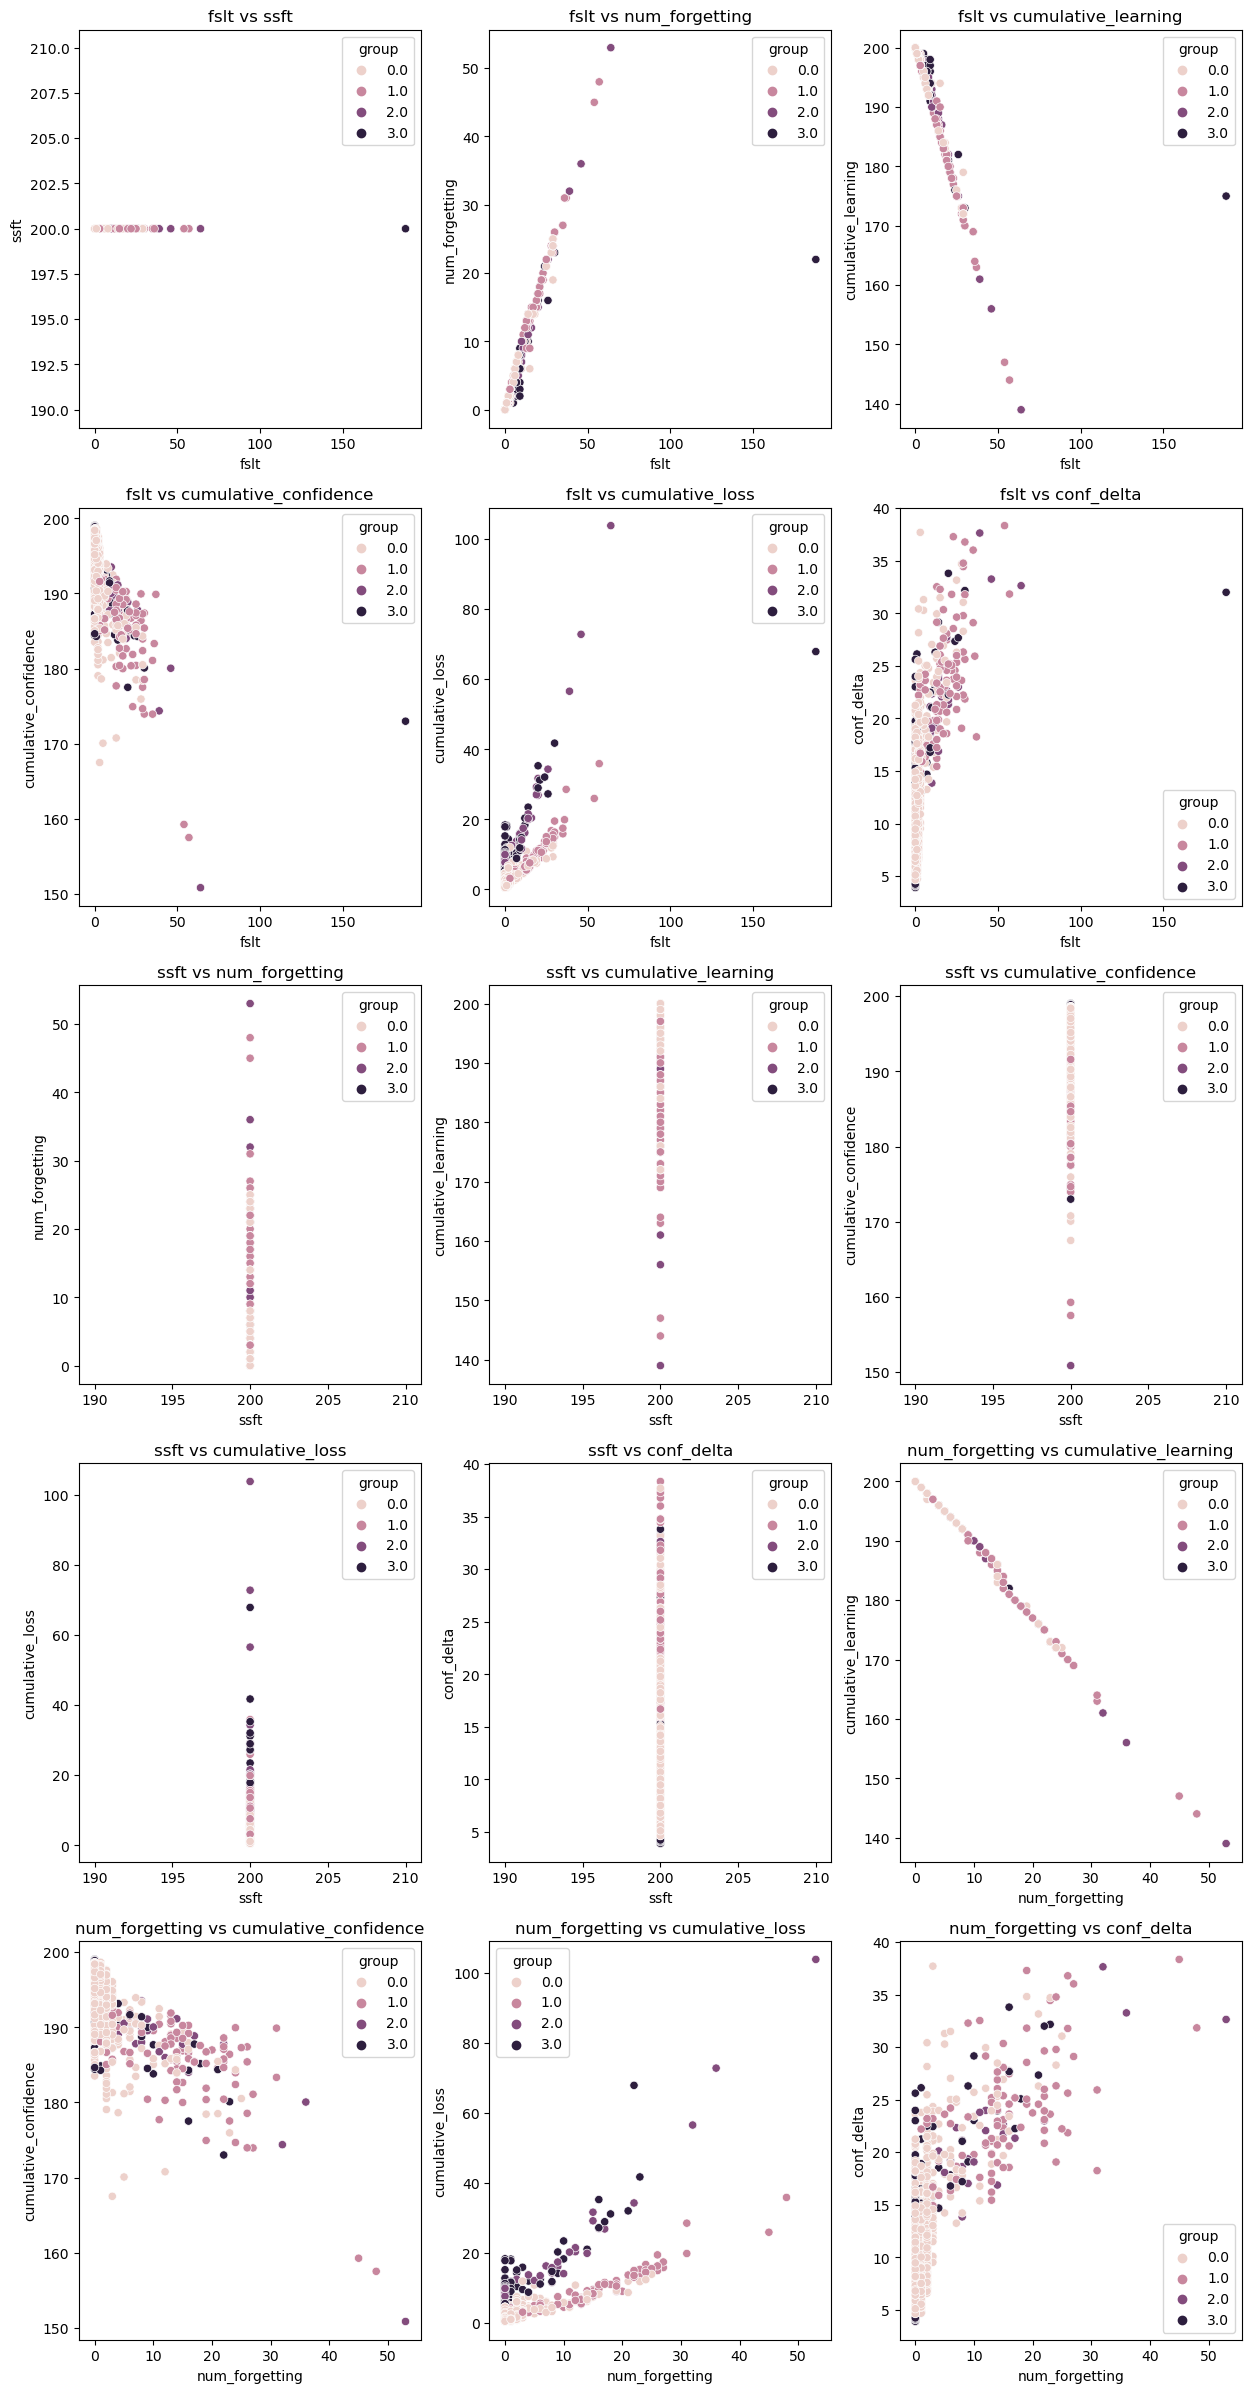

In [26]:
from itertools import combinations
print(len(list(combinations(metrics, 2))))
fig, axs = plt.subplots(5, 3, figsize=(15, 30))
for i, (x,y) in enumerate(list(combinations(metrics, 2))):
    sns.scatterplot(data=results, x=x, y=y, hue='group', ax=axs[i // 3, i % 3])
    axs[i // 3, i % 3].set_title(f'{x} vs {y}')

## Try removing the first few epochs

In [13]:
first_split[first_split['epoch'] > 5]

,image_id,stage,epoch,label,prediction,loss,conf,group
0,606,first-split,36,1.0,1.0,0.002090,0.997912,3.0
1,2588,first-split,36,0.0,0.0,0.026967,0.914652,0.0
2,3054,first-split,36,0.0,0.0,0.001304,0.995694,0.0
3,4390,first-split,36,0.0,0.0,0.000572,0.998110,0.0
4,4232,first-split,36,0.0,0.0,0.001530,0.994953,0.0
...,...,...,...,...,...,...,...,...
2393,3520,first-split,177,1.0,1.0,0.000131,0.999869,2.0
2394,2136,first-split,177,1.0,1.0,0.011487,0.988579,3.0
2395,4766,first-split,177,0.0,0.0,0.000534,0.998235,0.0
2396,2276,first-split,177,0.0,0.0,0.000114,0.999621,0.0


In [14]:
## get metrics

fslt = first_split.groupby('image_id', as_index=False).apply(calc_fslt)
fslt.columns = ['image_id', 'fslt']

ssft = second_split.groupby('image_id', as_index=False).apply(calc_ssft)
ssft.columns = ['image_id', 'ssft']

In [15]:
results = pd.concat([fslt, ssft], axis=1)
results = results.loc[:,~results.columns.duplicated()].copy()
results = results.merge(first_split[['image_id', 'group', 'label']].drop_duplicates(), on='image_id')
results

,image_id,fslt,ssft,group,label
0,0,0,200,3.0,1.0
1,2,0,200,3.0,1.0
2,4,1,200,3.0,1.0
3,6,0,200,3.0,1.0
4,8,0,200,3.0,1.0
...,...,...,...,...,...
2393,4786,1,200,0.0,0.0
2394,4788,0,200,0.0,0.0
2395,4790,0,200,0.0,0.0
2396,4792,0,200,0.0,0.0


<AxesSubplot:xlabel='fslt', ylabel='ssft'>

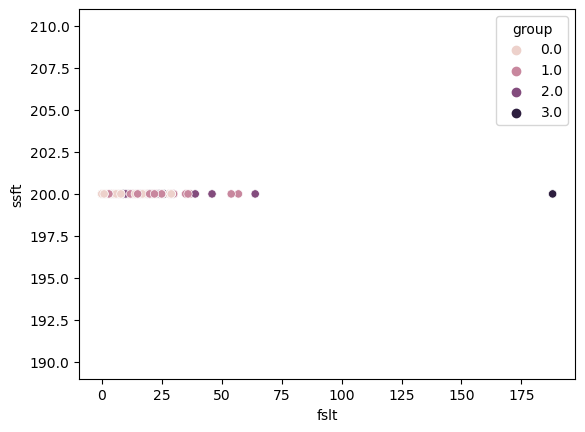

In [16]:
sns.scatterplot(x='fslt', y='ssft', data=results, hue='group')

In [19]:
second_split.sort_values('epoch', ascending=False)

,image_id,stage,epoch,label,prediction,loss,conf
0,4934,second-split,125,164.0,164.0,0.011385,0.987128
2093,248,second-split,125,8.0,8.0,0.043959,0.954097
2095,3652,second-split,125,121.0,121.0,0.054059,0.945612
2096,4914,second-split,125,163.0,163.0,0.000840,0.999073
2097,2590,second-split,125,86.0,86.0,0.004482,0.995220
...,...,...,...,...,...,...,...
1051,1512,second-split,0,50.0,50.0,0.019432,0.978786
1052,3904,second-split,0,130.0,130.0,0.040924,0.957196
1053,1036,second-split,0,34.0,34.0,0.025354,0.971561
1054,4838,second-split,0,161.0,161.0,0.040504,0.957627


<AxesSubplot:xlabel='epoch', ylabel='conf'>

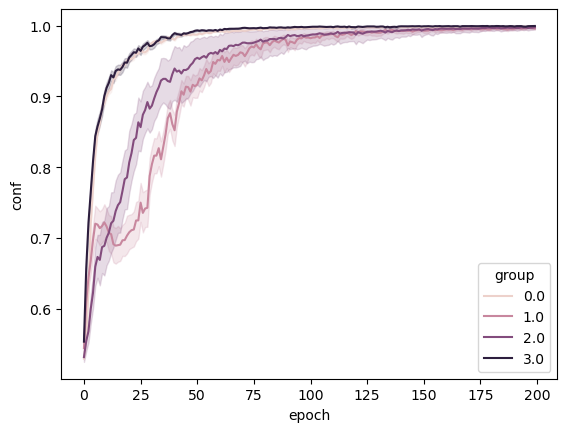

In [45]:
sns.lineplot(x='epoch', y='conf', hue='group', data=first_split)

<AxesSubplot:xlabel='epoch', ylabel='loss'>

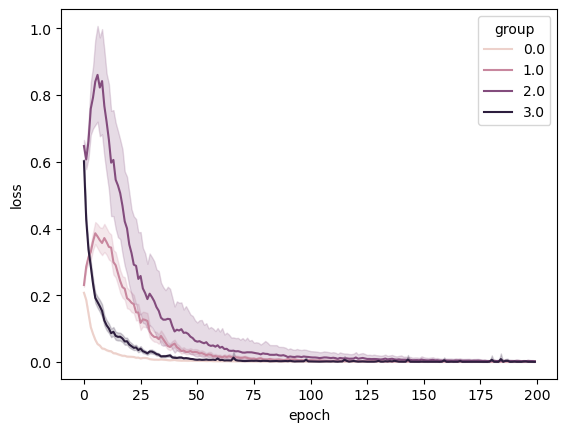

In [46]:
sns.lineplot(x='epoch', y='loss', hue='group', data=first_split)

## Try other seeds

In [24]:
args = OmegaConf.load('configs/waterbirds/base.yaml')
args.data.train_first_split = 'even'
base      = OmegaConf.load('configs/base.yaml')
args      = OmegaConf.merge(base, args)
args.exp.run = 'waterbirds-seed-2'

torch.manual_seed(args.seed)
np.random.seed(args.seed)

dataset = BaseDataset(get_dataset(args.data.dataset, cfg=args, split='train'), args)

runs = ['waterbirds-seed-1', 'waterbirds-seed-2', 'waterbirds-seed-3']
results_dir = f'predictions/{args.data.dataset}/{args.exp.run}'
first_split = pd.concat([pd.read_csv(f'{results_dir}/first-split/val-split/{f}') for f in os.listdir(os.path.join(results_dir, 'first-split', 'val-split'))])
val_all = pd.concat([pd.read_csv(f'{results_dir}/first-split/val-all/{f}') for f in os.listdir(os.path.join(results_dir, 'first-split', 'val-all'))])
# second_split = pd.concat([pd.read_csv(f'{results_dir}/second-split/{f}') for f in os.listdir(os.path.join(results_dir, 'second-split'))])

# add in group column if it doesn't exist
# if 'group' not in first_split.columns:
#     first_split['group'] = np.array(dataset.dataset.groups)[first_split['image_id'].values]

weights = dataset.class_weights.numpy()
# weights /= weights.min()
def weight_loss(loss, label):
    return loss / weights[int(label)]

first_split['loss'] = first_split.apply(lambda row : weight_loss(row['loss'],
                     row['label']), axis=1)
val_all['loss'] = val_all.apply(lambda row : weight_loss(row['loss'],
                     row['label']), axis=1)
first_split[:5]

Get dataset Waterbirds95


,image_id,stage,epoch,label,prediction,loss,conf,group
0,2280,first-split,109,0.0,0.0,0.000229,0.999771,0.0
1,312,first-split,109,0.0,0.0,0.003227,0.996778,0.0
2,4558,first-split,109,0.0,0.0,0.010856,0.989203,0.0
3,3024,first-split,109,0.0,0.0,0.000388,0.999612,0.0
4,2414,first-split,109,1.0,1.0,0.000690,0.999310,3.0


In [25]:
first_split.sort_values('epoch', ascending=False)

,image_id,stage,epoch,label,prediction,loss,conf,group
4,3974,first-split,199,0.0,0.0,0.000364,0.999636,0.0
1593,600,first-split,199,1.0,1.0,0.000006,0.999994,3.0
1595,4214,first-split,199,0.0,0.0,0.000946,0.999054,0.0
1596,2638,first-split,199,0.0,0.0,0.000284,0.999716,0.0
1597,4478,first-split,199,0.0,0.0,0.000134,0.999866,0.0
...,...,...,...,...,...,...,...,...
799,3594,first-split,0,0.0,1.0,0.806654,0.553651,0.0
800,2726,first-split,0,0.0,1.0,0.817917,0.558650,0.0
801,3680,first-split,0,0.0,1.0,0.735731,0.520845,0.0
802,2858,first-split,0,0.0,0.0,0.655580,0.519141,0.0


<AxesSubplot:xlabel='epoch', ylabel='loss'>

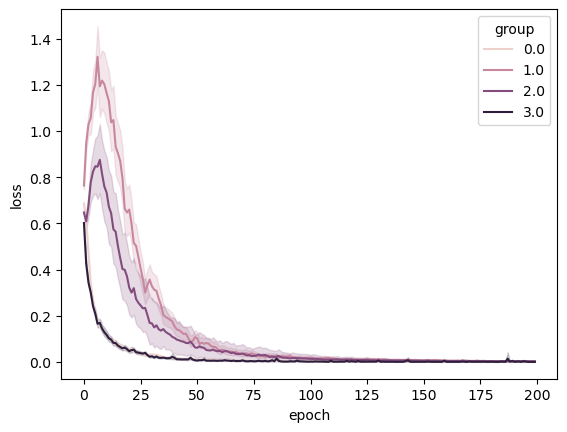

In [26]:
sns.lineplot(x='epoch', y='loss', hue='group', data=first_split)

In [33]:
# get low conf incorrect images
val_set = val_all[~val_all['image_id'].isin(first_split['image_id'].unique())]
val_set['inocorrect'] = val_set['label'] != val_set['prediction']
# val_set.groupby(["group", "inocorrect"])[['loss', 'conf']].mean()

/tmp/ipykernel_3775053/475699744.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_set['inocorrect'] = val_set['label'] != val_set['prediction']


In [38]:
runs = ['waterbirds-seed-1', 'waterbirds-seed-2', 'waterbirds-seed-3']
dfs = []
for r in runs:
    results_dir = f'predictions/{args.data.dataset}/{r}'
    df = pd.concat([pd.read_csv(f'{results_dir}/first-split/val-split/{f}') for f in os.listdir(os.path.join(results_dir, 'first-split', 'val-split'))])
    df['seed'] = int(r[-1])
    dfs.append(df)
df = pd.concat(dfs)

In [39]:
df

,image_id,stage,epoch,label,prediction,loss,conf,group,seed
0,346,first-split,14,0.0,0.0,0.005190,0.982978,0.0,1
1,1542,first-split,14,1.0,1.0,0.014935,0.985176,3.0,1
2,4380,first-split,14,0.0,0.0,0.011976,0.961156,0.0,1
3,3122,first-split,14,0.0,0.0,0.009626,0.968657,0.0,1
4,3020,first-split,14,0.0,0.0,0.023109,0.926400,0.0,1
...,...,...,...,...,...,...,...,...,...
2393,4542,first-split,175,0.0,0.0,0.000341,0.998871,0.0,3
2394,1048,first-split,175,1.0,1.0,0.000922,0.999079,3.0,3
2395,884,first-split,175,0.0,0.0,0.000068,0.999776,0.0,3
2396,2732,first-split,175,0.0,0.0,0.000009,0.999972,0.0,3
